# Final Project Submission

## Please fill out:
* Student name:
    - Carl Cook
* Student pace: 
    - Part-Time
* Scheduled project review date/time: 
    - NONE
* Instructor name: 
    - James Irving
* Blog post URL:
    - NONE

# Questions

## What genres perform the best?

### TMDB API

Here we use the TMDB API to gather our own information to work with. This is probably our best information source.

In [37]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt

#### Function to supply API key

In [38]:
def get_key(path):
    with open(path) as f:
        return json.load(f)

In [39]:
key = get_key("/Users/katma/.secret/tmdb_api.json")
api_key = key["api_key"]

#### Building DataFrame

In [40]:
columns = ['title', 'revenue', 'budget', 'genres', 'year', 'date']
df = pd.DataFrame(columns=columns)
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

#### Filling DataFrame

In [41]:
# Loops from 2010 to 2019
for x in years:
    print(x)
    page = 1
    # Grabs first 10 pages from API
    while page <= 10:
        url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
            '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=' + \
            str(page) + '&primary_release_year=' + str(x)
        print(url)
        by_year = requests.get(url)
        year = by_year.json()
        pages = year['total_pages']
        results = year['results']
        page += 1
        # Pulls information for each film on the current page
        for film in results:
            print(film['title'])
            try:
                film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                        '?api_key=' + api_key + '&language=en-US')
                film_rev = film_rev.json()
                details = [film['title'], film_rev['revenue'], film_rev['budget'],\
                           [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                           film_rev['release_date'][5:]]
                df.loc[len(df)]=details
            except:
                continue

2010
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=1&primary_release_year=2010
Toy Story 3
Alice in Wonderland
Harry Potter and the Deathly Hallows: Part 1
Inception
Shrek Forever After
The Twilight Saga: Eclipse
Iron Man 2
Tangled
Despicable Me
How to Train Your Dragon
The Chronicles of Narnia: The Voyage of the Dawn Treader
The King's Speech
TRON: Legacy
The Karate Kid
Tom and Jerry Meet Sherlock Holmes
Prince of Persia: The Sands of Time
Black Swan
Megamind
The Last Airbender
Robin Hood
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=2&primary_release_year=2010
Little Fockers
Resident Evil: Afterlife
Shutter Island
Salt
Sex and the City 2
The Tourist
The Expendables
Grown Ups
Knight and Day
True Grit
Gulliver's Travels
Clash of the Titans
Percy Jack

One Day
Killer Elite
Extremely Loud & Incredibly Close
The Tree of Life
Madea's Big Happy Family
The Roommate
The Mechanic
War of the Arrows
Conan the Barbarian
Sunny
Soul Surfer
Arthur
Beastly
Kokowääh
Fright Night
30 Minutes or Less
Monte Carlo
50/50
Oosaravelli
Mars Needs Moms
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=7&primary_release_year=2011
Dream House
Jumping the Broom
Larry Crowne
A Very Harold & Kumar Christmas
My Week with Marilyn
The Sitter
Jane Eyre
Courageous
Punch
Shaolin
Haywire
Detective K: Secret of Virtuous Widow
Silenced
I Don't Know How She Does It
What's Your Number?
A Few Best Men
Warriors of the Rainbow: Seediq Bale - Part 2: The Rainbow Bridge
Drive Angry
The Thing
Mankatha
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=8

Now You See Me
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=2&primary_release_year=2013
The Great Gatsby
The Smurfs 2
The Conjuring
A Good Day to Die Hard
Oblivion
Elysium
Turbo
We're the Millers
Epic
American Hustle
Cloudy with a Chance of Meatballs 2
Grown Ups 2
After Earth
Hansel & Gretel: Witch Hunters
Planes
White House Down
Percy Jackson: Sea of Monsters
Jack the Giant Slayer
The Secret Life of Walter Mitty
12 Years a Slave
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=3&primary_release_year=2013
Identity Thief
Anchorman 2: The Legend Continues
Olympus Has Fallen
The Heat
Jackass Presents: Bad Grandpa
47 Ronin
Lone Survivor
RED 2
Mama
Last Vegas
2 Guns
Walking with Dinosaurs
This Is the End
Ender's Game
Escape Plan
Prisoners
The Wind Rises
War

The Gambler
Million Dollar Arm
Devil's Due
Boonie Bears: To the Rescue
The Best of Me
When Marnie Was There
Forbidden Empire
Endless Love
Get on Up
The November Man
The Four 3
A Most Wanted Man
Tazza: The Hidden Card
Winter's Tale
When the Game Stands Tall
God's Not Dead
Big Eyes
Draft Day
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=8&primary_release_year=2014
The Divine Move
Wild Tales
Grace of Monaco
The Woman in Black 2: Angel of Death
That Awkward Moment
Iceman
Top Five
A Haunted House 2
And So It Goes
Jessabelle
Mrs. Brown's Boys D'Movie
2 States
Black or White
Yves Saint Laurent
Tinker Bell and the Pirate Fairy
Babysitting
Left Behind
The Drop
Veeram
Legends of Oz: Dorothy's Return
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=9&primary_relea

Central Intelligence
Bridget Jones's Baby
Me Before You
London Has Fallen
Arrival
The BFG
The Monkey King 2
A Aa
Royal Treasure
Bad Moms
Storks
Allegiant
Hacksaw Ridge
The Girl on the Train
Operation Mekong
The Huntsman: Winter's War
The Magnificent Seven
Jack Reacher: Never Go Back
Don't Breathe
The Accountant
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=4&primary_release_year=2016
Gods of Egypt
Lights Out
Pete's Dragon
Sausage Party
Lion
Mechanic: Resurrection
Ride Along 2
Deepwater Horizon
Allied
The Shallows
The Purge: Election Year
Why Him?
Office Christmas Party
How to Be Single
The 5th Wave
Neighbors 2: Sorority Rising
10 Cloverfield Lane
Cold War II
Railroad Tigers
Sultan
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=5&primary_release_year=2

Father and Son
The Big Bad Fox and Other Tales
Unforgettable
The Humanity Bureau
Loving Pablo
Bairavaa
Borg vs McEnroe
Six Degrees of Celebration 6
Seer Movie 6: Invincible Puni
Unknown Soldier
Finding Your Feet
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=9&primary_release_year=2017
Wonder Wheel
The Space Between Us
Tall Tales from the Magical Garden of Antoon Krings
Wish Upon
Vasco Modena Park - Il film
Toilet: A Love Story
Salyut-7
Megan Leavey
Da Hu Fa
Half Girlfriend
Battle of the Sexes
Jagga Jasoos
Before I Fall
Gautamiputra Satakarni
Roman J. Israel, Esq.
The Florida Project
Wished
Marrowbone
A Bag of Marbles
You Were Never Really Here
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=10&primary_release_year=2017
Furious
The Blacksmith
Kamen Ride

Pet Sematary
Abominable
The Upside
Scary Stories to Tell in the Dark
Rambo: Last Blood
Crawl
Yesterday
Jojo Rabbit
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=4&primary_release_year=2019
Serial (Bad) Weddings 2
Cats
Charlie's Angels
Good Boys
Doctor Sleep
What Men Want
After
EXIT
A Beautiful Day in the Neighborhood
White Snake
War
Cold Pursuit
Ready or Not
Kabir Singh
Saaho
Long Shot
Bombshell
Ma
Just Mercy
Uncut Gems
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=5&primary_release_year=2019
21 Bridges
Midsommar
Queen & Slim
A Madea Family Funeral
Child's Play
Hellboy
Playing with Fire
A Shaun the Sheep Movie: Farmageddon
My Mom is a Character 3
Fighting with My Family
Judy
Maharshi
Gully Boy
Richard Jewell
The Art of Racing in the Rain
The Good Lia

#### Check the DataFrame

In [42]:
df

,title,revenue,budget,genres,year,date
0,Toy Story 3,1066969703,200000000,"[Animation, Family, Comedy]",2010,06-16
1,Alice in Wonderland,1025467110,200000000,"[Family, Fantasy, Adventure]",2010,03-03
2,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,"[Adventure, Fantasy]",2010,10-17
3,Inception,825532764,160000000,"[Action, Science Fiction, Adventure]",2010,07-15
4,Shrek Forever After,752600867,165000000,"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16
...,...,...,...,...,...,...
1991,"One Love , Two Lives",1401422,0,"[Drama, Romance]",2019,02-15
1992,Wrong No. 2,1400000,0,"[Romance, Comedy]",2019,06-05
1993,El Chicano,1370000,0,"[Drama, Action, Crime]",2019,05-03
1994,Chhalawa,1300000,0,"[Comedy, Drama, Family, Romance]",2019,06-05


In [43]:
len(df.title.unique())

1992

In [44]:
df.shape

(1996, 6)

In [45]:
df.dtypes

title      object
revenue    object
budget     object
genres     object
year       object
date       object
dtype: object

#### Convert 'budget' and 'revenue' columns to numeric data

In [46]:
df['revenue'] = pd.to_numeric(df.revenue)
df['budget'] = pd.to_numeric(df.budget)

In [47]:
df.dtypes

title      object
revenue     int64
budget      int64
genres     object
year       object
date       object
dtype: object

#### Filter out films with revenue under $1M

In [48]:
df1 = df[df.revenue.gt(1000000)]

#### Explode 'genres' column so we can compare single genres

In [49]:
genre_df = df1.explode('genres')
genre_df.shape

(5130, 6)

In [50]:
genre_df.groupby(['year', 'genres']).mean().sort_values(['year', 'revenue'], ascending=False).head(20)

revenue        budget
year genres                                     
2019 Science Fiction  4.924485e+08  1.206176e+08
     Adventure        4.606954e+08  1.115714e+08
     Family           2.808875e+08  7.131111e+07
     Animation        2.340574e+08  4.666365e+07
     Action           2.185427e+08  6.123766e+07
     Fantasy          2.167856e+08  6.039139e+07
     Mystery          1.133265e+08  1.479130e+07
     Thriller         1.109072e+08  2.269645e+07
     Comedy           1.103256e+08  2.805747e+07
     Crime            1.047132e+08  2.606880e+07
     Horror           8.695294e+07  1.602273e+07
     Romance          7.874462e+07  1.698843e+07
     Drama            6.965347e+07  1.901188e+07
     War              6.822902e+07  3.057450e+07
     History          6.333776e+07  3.659754e+07
     Music            5.344923e+07  1.946381e+07
     Documentary      2.948430e+06  0.000000e+00
2018 Adventure        3.737049e+08  9.336125e+07
     Science Fiction  3.617935e+08  8.530000e+07
     Action           3.064245e+08  6.247300e+07

#### Create lists of genres for our plot

In [51]:
gen1 = ['Science Fiction', 'Adventure', 'Family']
gen2 = ['Animation', 'Action', 'Fantasy']
gen3 = ['Mystery', 'Thriller', 'Comedy']
gen4 = ['Crime', 'Horror', 'Romance']
gen5 = ['Drama', 'War', 'History']
gen6 = ['Music', 'Documentary', 'Western']

In [52]:
gen1_df = genre_df[genre_df.genres.isin(gen1)]
gen2_df = genre_df[genre_df.genres.isin(gen2)]
gen3_df = genre_df[genre_df.genres.isin(gen3)]
gen4_df = genre_df[genre_df.genres.isin(gen4)]
gen5_df = genre_df[genre_df.genres.isin(gen5)]
gen6_df = genre_df[genre_df.genres.isin(gen6)]

#### Plot average revenue by genre as compared to average revenue overall

Text(0, 0.5, 'Revenue (100M)')

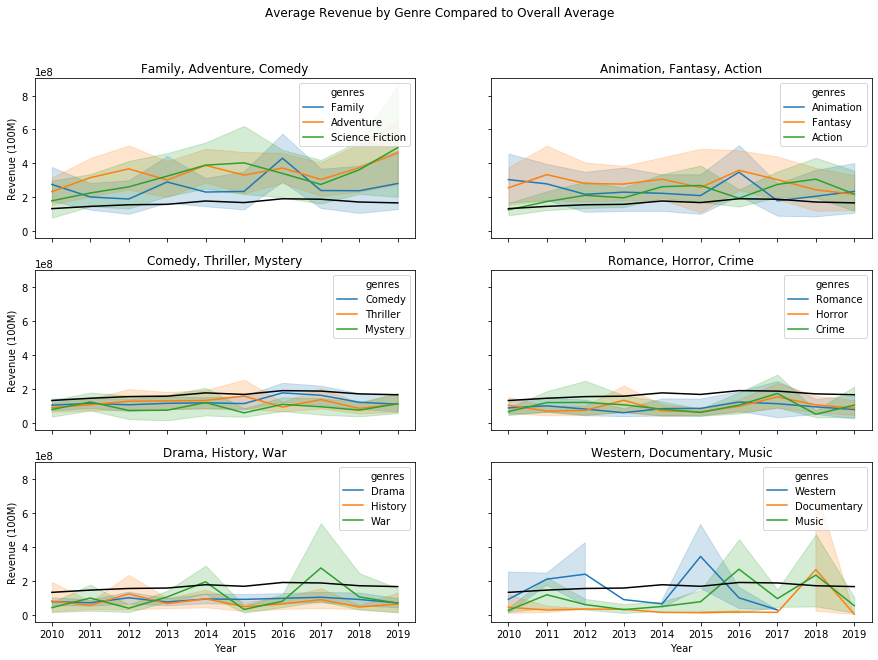

In [212]:
import seaborn as sns
fig, (ax1,ax2,ax3) = plt.subplots(3, 2, figsize=(15,10), sharex=True, sharey=True)

sns.lineplot(x='year', y='revenue', data=gen1_df, hue='genres', ax=ax1[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[0], color='black')
ax1[0].set_title('Family, Adventure, Comedy')

sns.lineplot(x='year', y='revenue', data=gen2_df, hue='genres', ax=ax1[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[1], color='black')
ax1[1].set_title('Animation, Fantasy, Action')

sns.lineplot(x='year', y='revenue', data=gen3_df, hue='genres', ax=ax2[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[0], color='black')
ax2[0].set_title('Comedy, Thriller, Mystery')

sns.lineplot(x='year', y='revenue', data=gen4_df, hue='genres', ax=ax2[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[1], color='black')
ax2[1].set_title('Romance, Horror, Crime')

sns.lineplot(x='year', y='revenue', data=gen5_df, hue='genres', ax=ax3[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[0], color='black')
ax3[0].set_title('Drama, History, War')

sns.lineplot(x='year', y='revenue', data=gen6_df, hue='genres', ax=ax3[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[1], color='black')
ax3[1].set_title('Western, Documentary, Music')

fig.suptitle("Average Revenue by Genre Compared to Overall Average")
ax3[0].set_xlabel("Year")
ax3[1].set_xlabel("Year")
ax1[0].set_ylabel("Revenue (100M)")
ax2[0].set_ylabel("Revenue (100M)")
ax3[0].set_ylabel("Revenue (100M)")

##### Here we can see that Family, Adventure, Sci-Fi, Animation, Fantasy, and Action all regularly perform better than average. Westerns, Documentaries, Music Movies, and War Movies are hit-or-miss from year-to-year, and the remaining genres regulary perform below the average.

#### Gathering information specific to 2019

In [54]:
year_19_df = genre_df[genre_df['year']=='2019'].sort_values('revenue', ascending=False)
year_19_df

,title,revenue,budget,genres,year,date
1796,Avengers: Endgame,2797800564,356000000,Adventure,2019,04-24
1796,Avengers: Endgame,2797800564,356000000,Action,2019,04-24
1796,Avengers: Endgame,2797800564,356000000,Science Fiction,2019,04-24
1797,The Lion King,1656943394,260000000,Adventure,2019,07-12
1797,The Lion King,1656943394,260000000,Family,2019,07-12
...,...,...,...,...,...,...
1994,Chhalawa,1300000,0,Drama,2019,06-05
1994,Chhalawa,1300000,0,Family,2019,06-05
1994,Chhalawa,1300000,0,Romance,2019,06-05
1995,Roger Waters: Us + Them,1294480,0,Documentary,2019,10-02


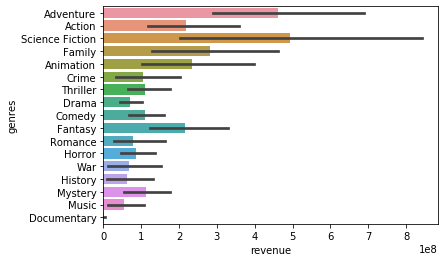

In [55]:
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres')

#### Gathering information specific to 2020

In [56]:
year_20_df = pd.DataFrame(columns=columns)
page = 1
while page <= 10:
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
      '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false' + \
      '&primary_release_year=2020&page=' + str(page)
    print(url)
    year_2020 = requests.get(url)
    year_2020 = year_2020.json()
    results = year_2020['results']
    page += 1
    for film in results:
        print(film['title'])
        try:
            film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                    '?api_key=' + api_key + '&language=en-US')
            film_rev = film_rev.json()
            details = [film['title'], film_rev['revenue'], film_rev['budget'],\
                       [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                       film_rev['release_date'][5:]]
            year_20_df.loc[len(year_20_df)]=details
        except:
            continue

https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&primary_release_year=2020&page=1
Bad Boys for Life
Sonic the Hedgehog
Dolittle
Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn)
The Invisible Man
The Gentlemen
The Call of the Wild
Onward
Scarlet Tulips
Fantasy Island
The Grudge
Underwater
Invasion
Ala Vaikunthapurramuloo
Bloodshot
Like a Boss
Emma.
Gretel & Hansel
Capone
Brahms: The Boy II
https://api.themoviedb.org/3/discover/movie?api_key=37d93a47466b976ea47e8585c7bdace0&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&primary_release_year=2020&page=2
The Turning
The Way Back
Street Dancer 3D
Malang
UFC 246: McGregor vs. Cowboy
Impractical Jokers: The Movie
Nightlife
Downhill
The Hunt
My Spy
Varane Avashyamund
Lassie Come Home
Trolls World Tour
The Perfect Date
Block Z
The Elfkins - Baking a Difference
Sudakshinar Saree
I Love Y

In [57]:
year_20_df

,title,revenue,budget,genres,year,date
0,Bad Boys for Life,191150000,0,"[Thriller, Action, Crime]",2020,01-15
1,Sonic the Hedgehog,306766470,85000000,"[Action, Science Fiction, Comedy, Family]",2020,02-12
2,Dolittle,223343452,175000000,"[Comedy, Fantasy, Adventure, Family]",2020,01-01
3,Birds of Prey (and the Fantabulous Emancipatio...,201858461,75000000,"[Action, Crime, Comedy]",2020,02-05
4,The Invisible Man,123414678,9000000,"[Thriller, Science Fiction, Horror]",2020,02-26
...,...,...,...,...,...,...
194,The Big Hit,0,0,"[Comedy, Drama]",2020,10-28
195,Say My Name,0,0,[Documentary],2020,05-12
196,Birthday Boy,0,0,[Drama],2020,06-05
197,16 Springs,0,0,[],2020,12-09


In [58]:
year_20_df.dtypes

title      object
revenue    object
budget     object
genres     object
year       object
date       object
dtype: object

#### Make 'budget' and 'revenue' numeric again

In [59]:
year_20_df['revenue'] = pd.to_numeric(year_20_df.revenue)
year_20_df['budget'] = pd.to_numeric(year_20_df.budget)

In [60]:
year_20_df.dtypes

title      object
revenue     int64
budget      int64
genres     object
year       object
date       object
dtype: object

#### Only use films with revenue over 1M to keep data comparable to previous years

In [61]:
year_20_df = year_20_df[year_20_df.revenue.gt(1000000)]

In [62]:
year_20_df = year_20_df.explode('genres')

In [63]:
year_20_df

,title,revenue,budget,genres,year,date
0,Bad Boys for Life,191150000,0,Thriller,2020,01-15
0,Bad Boys for Life,191150000,0,Action,2020,01-15
0,Bad Boys for Life,191150000,0,Crime,2020,01-15
1,Sonic the Hedgehog,306766470,85000000,Action,2020,02-12
1,Sonic the Hedgehog,306766470,85000000,Science Fiction,2020,02-12
...,...,...,...,...,...,...
32,Trolls World Tour,1946164,0,Family,2020,03-12
32,Trolls World Tour,1946164,0,Comedy,2020,03-12
32,Trolls World Tour,1946164,0,Fantasy,2020,03-12
32,Trolls World Tour,1946164,0,Adventure,2020,03-12


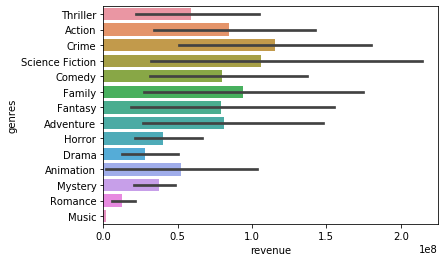

In [64]:
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres')

#### Plot to compare average revenue by genre from 2019 to 2020 so far

Text(0.5, 0.98, 'Average Revenues by Genre in 2019, 2020')

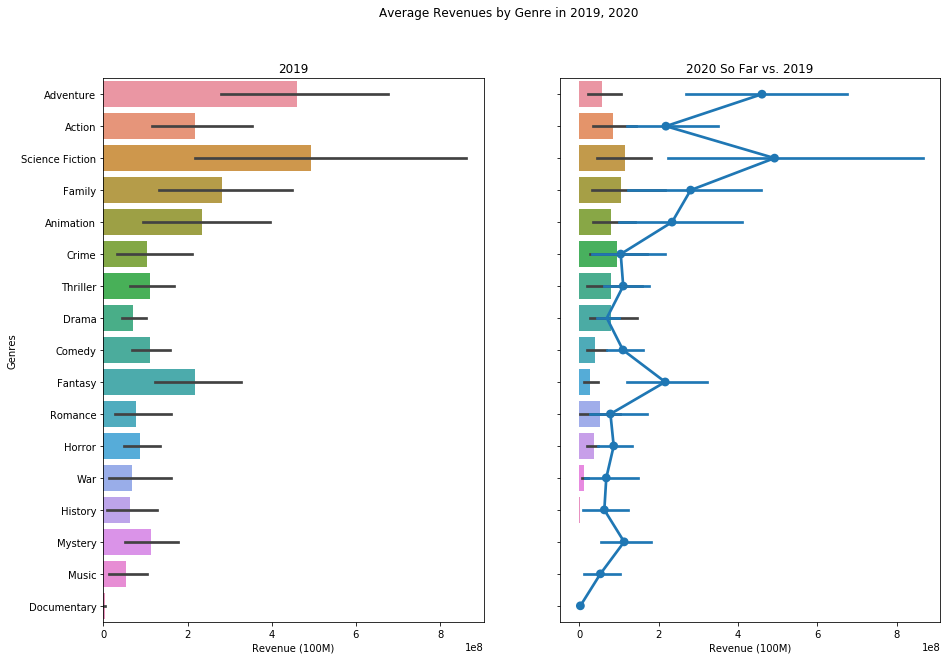

In [65]:
fig, ax1 = plt.subplots(1, 2, figsize=(15,10), sharey=True)
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres', ax=ax1[0])
ax1[0].set_title("2019")
ax1[0].set_xlabel("Revenue (100M)")
ax1[0].set_ylabel('Genres')
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres', ax=ax1[1])
sns.pointplot(data=year_19_df, x='revenue', y='genres', ax=ax1[1])
ax1[1].set_title('2020 So Far vs. 2019')
ax1[1].set_xlabel('Revenue (100M)')
ax1[1].set_ylabel("")
fig.suptitle("Average Revenues by Genre in 2019, 2020")

## How does a film's budget affect its performance?

The file 'tn.movie_budgets.csv.gz' contains all the needed information for this, so we just put it into a dataframe and make a simple regression plot.

Text(0, 0.5, 'Revenue (1B)')

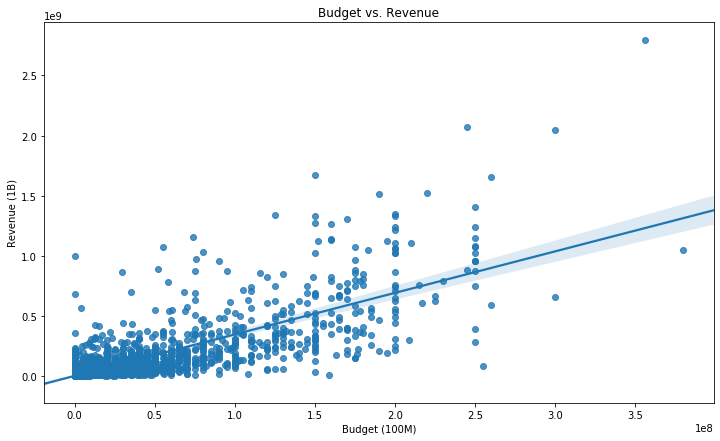

In [66]:
fig, ax = plt.subplots(figsize=(12,7))
sns.regplot(data=df, x='budget', y='revenue')
ax.set_title('Budget vs. Revenue')
ax.set_xlabel('Budget (100M)')
ax.set_ylabel('Revenue (1B)')

##### This shows a strong relationship between a film's budget and its revenue. Not surprisingly, the more money invested in a film, the more you can expect in revenue, as a general rule.

## What is the effect of release date on expected revenue?

In [67]:
df.head()

,title,revenue,budget,genres,year,date
0,Toy Story 3,1066969703,200000000,"[Animation, Family, Comedy]",2010,06-16
1,Alice in Wonderland,1025467110,200000000,"[Family, Fantasy, Adventure]",2010,03-03
2,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,"[Adventure, Fantasy]",2010,10-17
3,Inception,825532764,160000000,"[Action, Science Fiction, Adventure]",2010,07-15
4,Shrek Forever After,752600867,165000000,"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16


#### Getting the month from the date column

In [69]:
df['month'] = [[x][0][:2] for x in df['date']]
df.head()

,title,revenue,budget,genres,year,date,month
0,Toy Story 3,1066969703,200000000,"[Animation, Family, Comedy]",2010,06-16,06
1,Alice in Wonderland,1025467110,200000000,"[Family, Fantasy, Adventure]",2010,03-03,03
2,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,"[Adventure, Fantasy]",2010,10-17,10
3,Inception,825532764,160000000,"[Action, Science Fiction, Adventure]",2010,07-15,07
4,Shrek Forever After,752600867,165000000,"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,05


#### Using month to determine quarter

In [93]:
import math
df['quarter'] = [math.ceil(int(x)/3) for x in df['month']]
df

,title,revenue,budget,genres,year,date,month,quarter
0,Toy Story 3,1066969703,200000000,"[Animation, Family, Comedy]",2010,06-16,06,2
1,Alice in Wonderland,1025467110,200000000,"[Family, Fantasy, Adventure]",2010,03-03,03,1
2,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,"[Adventure, Fantasy]",2010,10-17,10,4
3,Inception,825532764,160000000,"[Action, Science Fiction, Adventure]",2010,07-15,07,3
4,Shrek Forever After,752600867,165000000,"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,05,2
...,...,...,...,...,...,...,...,...
1991,"One Love , Two Lives",1401422,0,"[Drama, Romance]",2019,02-15,02,1
1992,Wrong No. 2,1400000,0,"[Romance, Comedy]",2019,06-05,06,2
1993,El Chicano,1370000,0,"[Drama, Action, Crime]",2019,05-03,05,2
1994,Chhalawa,1300000,0,"[Comedy, Drama, Family, Romance]",2019,06-05,06,2


#### Plot by quarter for 2010-2019

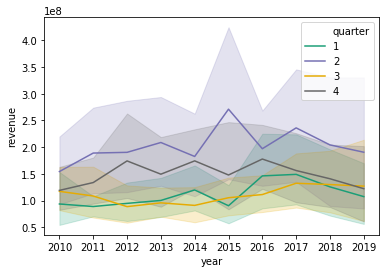

In [215]:
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2')

#### find release quarters for 2020

In [199]:
year_20_df['month'] = [[x][0][:2] for x in year_20_df['date']]
year_20_df['quarter'] = [math.ceil(int(x)/3) for x in year_20_df['month']]
year_20_df.groupby('quarter').count()

,title,revenue,budget,genres,year,date,month
quarter,,,,,,,
1,89,89,89,88,89,89,89
2,2,2,2,2,2,2,2


#### Plot 2020 by month since there are only 2 quarters to show

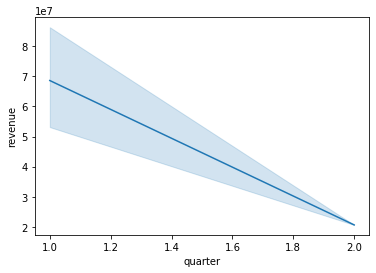

In [216]:
sns.lineplot(data=year_20_df, x='quarter', y='revenue')

#### Show plot comparing past years quarterly to this year

Text(0.5, 0.98, 'A Comparison of Revenue by Release Schedule')

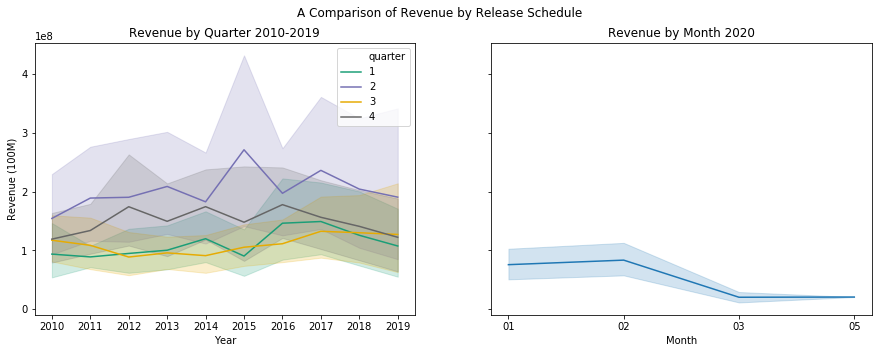

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2', ax=axes[0])
sns.lineplot(data=year_20_df, x='month', y='revenue', ax=axes[1])
axes[0].set_title('Revenue by Quarter 2010-2019')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue (100M)')
axes[1].set_title('Revenue by Month 2020')
axes[1].set_xlabel('Month')
fig.suptitle("A Comparison of Revenue by Release Schedule")

##### Here we can see that we can expect a bump in revenue in quarters 2 and 4. So, the best time to release our film is in the summer or during the holiday season. 2020 has not gotten its quarter 2 bump, presumably due to Covid-19 restrictions.

### Recommendation: Big budget Sci-Fi/Adventure film to release in summer or the holiday season. Revenues are currently below expectations due to Covid-19, but we can expect that slump to be over before the film finishes production.